# Assignment 4: Hough Transform

## Ex. 4.1 Detect lanes and eyes

* there are two datasets available: "images/eye_tracking" and "images/lane_detection" - decide for one of them
* implement the classical Hough Transform for lines (for lane detection) **OR** circles (eye tracking) as shown in the lecture
* use a Canny edge detector to produce edge images for the sequence of images

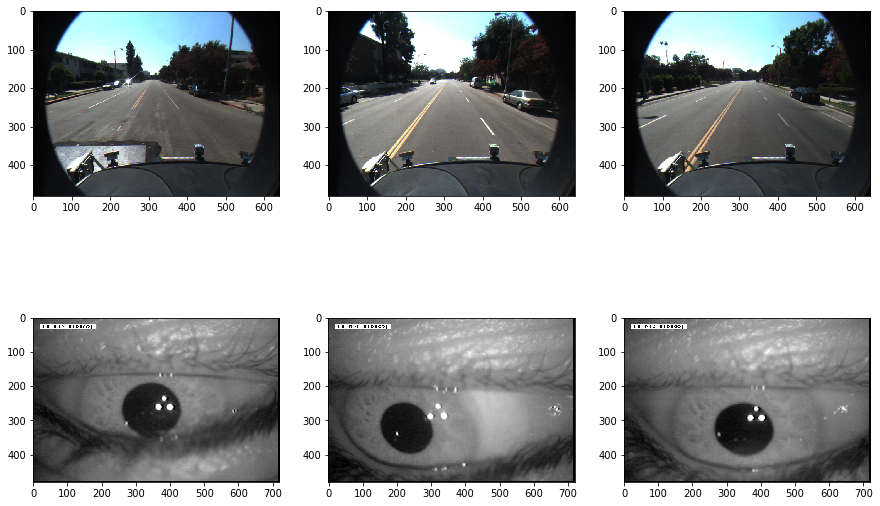

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color
import numpy as np

lane1 = io.imread('images/lane_detection/f00000.png')
lane2 = io.imread('images/lane_detection/f00050.png')
lane3 = io.imread('images/lane_detection/f00090.png')

eye1 = io.imread('images/eye_tracking/0000.jpeg')
eye2 = io.imread('images/eye_tracking/0050.jpeg')
eye3 = io.imread('images/eye_tracking/0090.jpeg')

fig = plt.figure(figsize=(15, 10))
ax11 = plt.subplot(2, 3, 1)
ax12 = plt.subplot(2, 3, 2)
ax13 = plt.subplot(2, 3, 3)
ax21 = plt.subplot(2, 3, 4)
ax22 = plt.subplot(2, 3, 5)
ax23 = plt.subplot(2, 3, 6)



ax11.imshow(lane1)
ax12.imshow(lane2)
ax13.imshow(lane3)

ax21.imshow(eye1)
ax22.imshow(eye2)
ax23.imshow(eye3)

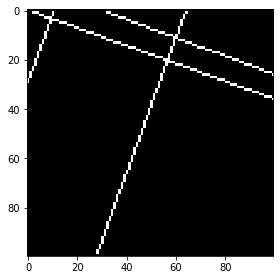

In [2]:
# dieser Code wurde als Musterlösung von Sebastian Oltmanns zur Verfügung gestellt und von Tim renoviert

%matplotlib inline
from skimage.draw import line
from skimage import io
import math
import numpy as np

def draw_line_hessian_normal(image, a, r):
    
    (dimy,dimx) = image.shape

    #r = x*cosa + y*sina

    # compute start and end point of line 
    x0 = 0
    y0 = round((r - x0*math.cos(math.radians(a)))/math.sin(math.radians(a)))
    x1 = dimx
    y1 = round((r - x1*math.cos(math.radians(a)))/math.sin(math.radians(a)))

    liney,linex = line(y0,x0,y1,x1)
    
    ret = np.copy(image)
    for yy in range(0,liney.size-1):
        if (liney[yy] > 0) and (liney[yy] < dimy-1):
            ret[liney[yy],linex[yy]] = 1
    return ret

image = np.zeros((100,100))
image = draw_line_hessian_normal(image, 20, 60)
image = draw_line_hessian_normal(image, 20, 10)
image = draw_line_hessian_normal(image, 110, 0)
image = draw_line_hessian_normal(image, -70, 10)
io.imshow(image)

## OPTION 1: line detection for lane detection 

* use your implementation of the Hough Transform to find the 10 strongest lines in the image
* display your result set (draw those lines on the image) (**RESULT**)
* can you improve the performance by limiting the space of solutions? implement and draw lines again! (**BONUS**)

## OPTION 2: circle detection for eye detection
* use your implementation of the Hough Transform to find the 10 strongest circles in the image
* display your result set (draw those circles on the image) (**RESULT**)
* can you improve the performance by limiting the space of solutions? implement and draw circles again! (**BONUS**)

# Ex. 3.2 Generalized Hough Transform

* implement the Generalized Hough Transform as described in the lecture for localizing a given template
* find the given template (see below) and mark its location in the image "animals.png" (**RESULT**)

## BONUS 
* now implement an extended version of the GHT that find rotated and scaled variants of the template. 
* find Italy (see "italy.jpg") and the map of Europe ("europe_map_political.gif")
* note that you can binarize your italy template by using a simple color lookup
* draw the location of italy on the map and print its scale and orientation (**BONUS**)

/home/manar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


NameError: name 'dilation' is not defined

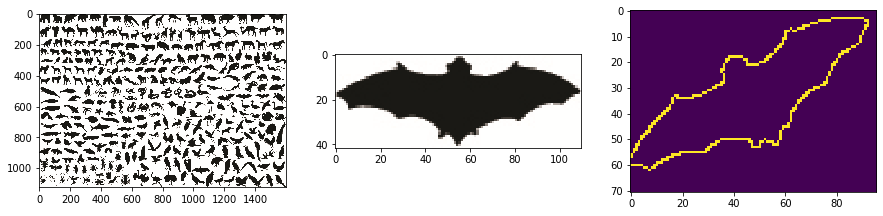

In [11]:
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math, cv2
from skimage import io, data, feature, color, measure, filters, transform

import numpy as np

animals = io.imread('images/animals.png')

xmin = 1271
xmax = 1381
ymin = 519
ymax = 561

bat = animals[ymin:ymax, xmin:xmax]

bat_edge_scaled = feature.canny(color.rgb2gray(transform.resize(bat, (126, 330))), 2)
bat_edge = feature.canny(color.rgb2gray(bat), 1)
bat_edge_rotated  = feature.canny(color.rgb2gray(transform.rotate(bat, 30, resize=True, cval=1)), 1)[10:-10,10:-10]
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)
ax4 = plt.subplot(1, 3, 3)

ax1.imshow(animals)
ax2.imshow(bat)
ax3.imshow(bat_edge)
ax4.imshow(bat_edge_rotated)


angleDiscrete = np.arange(20, 360, 20)
animals = animals[500:, 500:]
temp = animals
kernel = np.ones((3,3),np.uint8)
erosion = cv2.erode(animals,kernel,iterations = 2)

animals = feature.canny(color.rgb2gray(erosion), 1)

def getObjectsFeatures(tObject):
    G, newObj = sobel_filters(tObject)
    result = [[] for i in angleDiscrete] 
    for i in range(0, len(result)):
        result[i] = 0
    for (itIdx, it) in enumerate(newObj):
        for (otIdx, ot) in enumerate(it):
            if(tObject[itIdx, otIdx] != 0):
                #result[getAngle((itIdx, otIdx), (len(tObject[0]), len(tObject)))].append(ot)
                discreteAngle = getAngleDiscrete(ot)
                result[discreteAngle] = result[discreteAngle] + 1
    return np.array(result)

def unit_vector(vector):
    return vector / np.linalg.norm(vector)


def conv2d(image, kernel):
    m, n = kernel.shape
    y, x = image.shape
    y = y - m + 1
    x = x - m + 1
    result = np.zeros((y,x))
    for i in range(y):
        for j in range(x):
            result[i][j] = np.sum(image[i:i+m, j:j+m]*kernel)
    return result

def sobel_filters(img):
    Kernal_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Kernal_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = conv2d(img, Kernal_x)
    Iy = conv2d(img, Kernal_y)
    sobelx = cv2.Sobel(np.float32(img), cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(np.float32(img), cv2.CV_64F, 0, 1, ksize=3)
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(sobely, sobelx)
    
    return G, theta

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    #return math.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))
    x = math.degrees(math.atan2(v2[1]-v1[1], v2[0]-v1[0]))
    if(x<0):
        x = 360 + x
    return x

def getAngle(vector, centroid):
    idx = 0
    for i in range(len(angleDiscrete)-1, 0, -1):
        if(angle_between(vector, centroid) > angleDiscrete[i]):
            idx = i
            break;
    return idx;
def getAngleDiscrete(angle):
    idx = 0
    angle = 180.0 + angle / math.pi * 180.0
    if(angle < 0): angle = 360 + angle
    for i in range(len(angleDiscrete)-1, -1, -1):
        if(angle >= angleDiscrete[i]):
            idx = i
            break;
    return idx;


def getObjectsVote(ymin,ymax,xmin,xmax,centroid, mainImage):
    result = [[] for i in angleDiscrete] 
    for i in range(0, len(result)):
        result[i] = 0
    G, tObject = sobel_filters(mainImage[ymin:ymax, xmin:xmax])
    for (itIdx, it) in enumerate(tObject):
        for (otIdx, ot) in enumerate(it):
            if(mainImage[ymin+itIdx, xmin+otIdx] != 0):
                #result[getAngle((ymin+ itIdx, xmin + otIdx), centroid)].append(ot)
                #result[getAngle((ymin+ itIdx, xmin + otIdx), centroid)] = result[getAngle((ymin+ itIdx, xmin + otIdx), centroid)] + 1
                result[getAngleDiscrete(ot)] = result[getAngleDiscrete(ot)] + 1
    return np.array(result)

def calculateDistance(v1, v2, v1ov2):
    minDist = 999999
    rotation = 0
    tempV= 0
    for i in range(0, len(v1)):
        dist = np.linalg.norm(((v1))-(v2*math.sqrt(v1ov2)))
        if(dist < minDist):
            minDist = dist
            rotation = i
            tempV = v1
        v1 = np.roll(v1, 1)
    print("Rotated vector")
    print(np.roll(tempV, rotation))
    return rotation, minDist

def findObject(image, targetObject, targetObjectArea, coloredImage):
    dist = 999999
    rect = '' # rect to mark result object
    all_labels = measure.label(image)
    for region in measure.regionprops(all_labels):
        if(region.bbox_area > 1000  ):
            minr, minc, maxr, maxc = region.bbox
            fig = plt.figure(figsize=(15, 10))
  #          ax1 = plt.subplot(1, 3, 1)
  #          ax1.imshow(image)
  #          ax1.add_patch(patches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2))
            objectVote = getObjectsVote(minr, maxr, minc, maxc, region.centroid, image)
            rotation, newDist = calculateDistance(objectVote, targetObject, region.bbox_area/targetObjectArea)
  #          print(targetObject)
            print('.')
            plt.tight_layout()
            plt.show()
            if( newDist < dist):
                rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
            if(newDist < 20):
                break
    return rect

targetObject = getObjectsFeatures(bat_edge_rotated)
targetObjectArea = len(bat_edge) * len(bat_edge[0])

targetObjectScaled = getObjectsFeatures(bat_edge_scaled)
targetObjectScaledArea = len(bat_edge_scaled) * len(bat_edge_scaled[0])

#rect = findObject(animals, targetObject, targetObjectArea )


world = io.imread('images/europe_map_political.gif')[400:,:]

italy = io.imread('images/italy.jpg')
lowe_bound=np.array([240,200,70])
upper_bound=np.array([275,220, 100])
binary_output = cv2.inRange(italy, lowe_bound, upper_bound)

kernel = np.ones((3,3),np.uint8)
#dilation = cv2.dilate(binary_output,kernel,iterations = 7)
dialation = binary_output
italyEdges = feature.canny(dilation, 2)

italyObject = getObjectsFeatures(italyEdges)
italyObjectArea = len(italyEdges) * len(italyEdges[0])
ax2.imshow(feature.canny(color.rgb2gray(world),2))

rect = findObject(feature.canny(color.rgb2gray(world), 2), italyObject, italyObjectArea, world )

fig = plt.figure(figsize=(15, 10))        
ax2 = plt.subplot(1, 3, 1)
ax2.add_patch(rect)        

    #if region.area >= 100:
        # draw rectangle around segmented coins
     #   minr, minc, maxr, maxc = region.bbox
      #  rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
       #                           fill=False, edgecolor='red', linewidth=2)
       # ax.add_patch(rect)
print("Finish")        
ax2.set_axis_off()
plt.tight_layout()
plt.show()
#def iterateImageObjects():
    

#def objectsVotes(imageObject):
    #iterate objects gradients:
        #find p-c 
        #fill in the vote
    #return matrix with votes:    

/home/manar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


.47.70744176750625
.177.2060947033143
.127.251719045363
.142.90906199398273
.52.66877632905477
.83.24662155306964
.63.166446789415026
.33.97057550292606
.210.11187496188785
.139.12584231550946
.106.59737332598773
.52.41183072551463
.130.78226179417453
.38.97435053981015
.113.3181362359971
.210.29265322402492
.44.48595283907045
.147.3295625460145
.96.8039255402383
.110.81967334368028
.202.66968199511243
.86.20904824900923
.40.90232267243512
.70.8590149522275
.58.86425061104575
.80.49223565040295
.236.03813251252433
.128.17175976009693
.127.09445306542689
.166.33400133466398
.161.35055004554525
.38.47076812334269
.135.19615379144483
.50.67543783727971
.86.38286867197685
.71.35124385741288
.55.44366510251645
.97.2265395866787
.51.884487084291386
.30.331501776206203
.94.66255859631093
.117.97457353175726
.45.73838650411709
.127.70277992275658
.110.41286156965592
.64.99230723708769
.113.02212172844747
.155.88778014969614
.60.049979184009715
.54.35991169970753
.60.60528029800704
.50.24937810

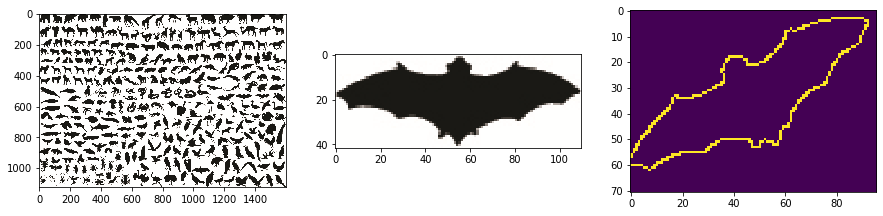

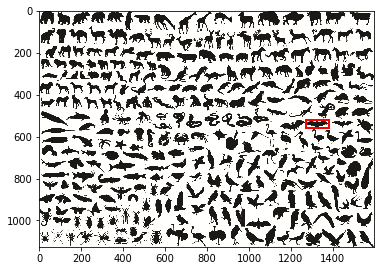

Now finding scaled bat


TypeError: getObjectsFeatures() missing 1 required positional argument: 'centroid'

In [28]:
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math, cv2
from scipy.spatial import distance
from skimage import io, data, feature, color, measure, filters, transform

import numpy as np

animals = io.imread('images/animals.png')

xmin = 1271
xmax = 1381
ymin = 519
ymax = 561

bat = animals[ymin:ymax, xmin:xmax]

bat_edge_scaled = feature.canny(color.rgb2gray(transform.resize(bat, (126, 330))), 2)
bat_edge = feature.canny(color.rgb2gray(bat), 1)
bat_edge_rotated  = feature.canny(color.rgb2gray(transform.rotate(bat, 30, resize=True, cval=1)), 1)[10:-10,10:-10]
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)
ax4 = plt.subplot(1, 3, 3)

ax1.imshow(animals)
ax2.imshow(bat)
ax3.imshow(bat_edge)
ax4.imshow(bat_edge_rotated)


angleDiscrete = np.arange(20, 360, 20)
#animals = animals[500:, 500:]
temp = animals
animals = feature.canny(color.rgb2gray(animals), 1)

def getObjectsFeatures(tObject, centroid):
    G, newObj = sobel_filters(tObject)
    result = [[] for i in angleDiscrete] 
    for i in range(0, len(result)):
        result[i] = 0
    for (itIdx, it) in enumerate(newObj):
        for (otIdx, ot) in enumerate(it):
            if(tObject[itIdx, otIdx] != 0):
                #result[getAngle((itIdx, otIdx), (len(tObject[0]), len(tObject)))].append(ot)
                discreteAngle = getAngleDiscrete(ot)
                result[discreteAngle] = result[discreteAngle] + 1
                #result[discreteAngle] = result[discreteAngle] + np.linalg.norm((otIdx-centroid[0], itIdx-centroid[1]))
    return np.array(result)

def getObjectsVote(ymin,ymax,xmin,xmax,centroid, mainImage):
    result = [[] for i in angleDiscrete] 
    for i in range(0, len(result)):
        result[i] = 0
    G, tObject = sobel_filters(mainImage[ymin:ymax, xmin:xmax])
    for (itIdx, it) in enumerate(tObject):
        for (otIdx, ot) in enumerate(it):
            if(mainImage[ymin+itIdx, xmin+otIdx] != 0):
                #result[getAngle((ymin+ itIdx, xmin + otIdx), centroid)].append(ot)
                #result[getAngle((ymin+ itIdx, xmin + otIdx), centroid)] = result[getAngle((ymin+ itIdx, xmin + otIdx), centroid)] + 1
                result[getAngleDiscrete(ot)] = result[getAngleDiscrete(ot)] + 1
                #result[getAngleDiscrete(ot)] = result[getAngleDiscrete(ot)] + np.linalg.norm((otIdx-centroid[0], itIdx-centroid[1]))
    return np.array(result)

def unit_vector(vector):
    return vector / np.linalg.norm(vector)


def conv2d(image, kernel):
    m, n = kernel.shape
    y, x = image.shape
    y = y - m + 1
    x = x - m + 1
    result = np.zeros((y,x))
    for i in range(y):
        for j in range(x):
            result[i][j] = np.sum(image[i:i+m, j:j+m]*kernel)
    return result

def sobel_filters(img):
    Kernal_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Kernal_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = conv2d(img, Kernal_x)
    Iy = conv2d(img, Kernal_y)
    sobelx = cv2.Sobel(np.float32(img), cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(np.float32(img), cv2.CV_64F, 0, 1, ksize=3)
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(sobely, sobelx)
    
    return G, theta

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    #return math.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))
    x = math.degrees(math.atan2(v2[1]-v1[1], v2[0]-v1[0]))
    if(x<0):
        x = 360 + x
    return x

def getAngle(vector, centroid):
    idx = 0
    for i in range(len(angleDiscrete)-1, 0, -1):
        if(angle_between(vector, centroid) > angleDiscrete[i]):
            idx = i
            break;
    return idx;
def getAngleDiscrete(angle):
    idx = 0
    angle = 180.0 + angle / math.pi * 180.0
    if(angle < 0): angle = 360 + angle
    for i in range(len(angleDiscrete)-1, -1, -1):
        if(angle >= angleDiscrete[i]):
            idx = i
            break;
    return idx;




def calculateDistance(v1, v2, v1ov2):
    minDist = 999999
    rotation = 0
    tempV= 0
    for i in range(0, len(v1)):
        dist = np.linalg.norm(((v1))-(v2*math.sqrt(v1ov2)))
        if(dist < minDist):
            minDist = dist
            rotation = i
            tempV = v1
        v1 = np.roll(v1, 1)
    return rotation, minDist

def findObject(image, targetObject, targetObjectArea, coloredImage):
    dist = 999999
    rect = '' # rect to mark result object
    all_labels = measure.label(image)
    for region in measure.regionprops(all_labels):
        if(region.bbox_area > 3000  ):
            minr, minc, maxr, maxc = region.bbox
            objectVote = getObjectsVote(minr, maxr, minc, maxc, region.centroid, image)
            #rotation, newDist = calculateDistance(objectVote, targetObject, region.bbox_area/targetObjectArea)
            newDist = np.linalg.norm(((objectVote))-(targetObject))
            print('.', end = '')
            print(newDist)
            if( newDist < dist):
                rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
                dist = newDist
    return rect

targetObject = getObjectsFeatures(bat_edge, (len(bat_edge[0])/2,len(bat_edge)/2))
targetObjectArea = len(bat_edge) * len(bat_edge[0])

#targetObjectScaled = getObjectsFeatures(bat_edge_scaled)
#targetObjectScaledArea = len(bat_edge_scaled) * len(bat_edge_scaled[0])

rect = findObject(animals, targetObject, targetObjectArea, temp )


fig = plt.figure(figsize=(15, 10))        
ax2 = plt.subplot(1, 3, 1)
ax2.imshow(temp)
ax2.add_patch(rect)        
plt.tight_layout()
plt.show()
    #if region.area >= 100:
        # draw rectangle around segmented coins
     #   minr, minc, maxr, maxc = region.bbox
      #  rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
       #                           fill=False, edgecolor='red', linewidth=2)
       # ax.add_patch(rect)
print("Now finding scaled bat")        

targetObjectScaled = getObjectsFeatures(bat_edge_scaled)
targetObjectScaledArea = len(bat_edge_scaled) * len(bat_edge_scaled[0])

rect = findObject(animals, targetObjectScaled, targetObjectScaledArea, temp )


fig = plt.figure(figsize=(15, 10))        
ax2 = plt.subplot(1, 3, 1)
ax2.imshow(temp)
ax2.add_patch(rect)        
plt.tight_layout()
plt.show()
#def iterateImageObjects():
    

#def objectsVotes(imageObject):
    #iterate objects gradients:
        #find p-c 
        #fill in the vote
    #return matrix with votes:    